<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/1_extract_persona_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1: Extract Persona Vectors (Layers 5-20)

This notebook extracts demographic steering vectors from **multiple layers (5-20)** of Meta-Llama-3-8B-Instruct.

**Output:** One vector file per layer:
- `gss_demographic_vectors_layer5.pt`
- `gss_demographic_vectors_layer6.pt`
- ...
- `gss_demographic_vectors_layer20.pt`

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 29.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import os

In [3]:
# Link to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
# Load extraction_datasets.json
import json
with open("/content/drive/MyDrive/belief_and_llms_v0/gss_extraction_datasets.json", "r") as f:
    extraction_datasets = json.load(f)

print(f"Loaded {len(extraction_datasets)} demographic groups.")
print("Groups:", list(extraction_datasets.keys())[:5], "...")

Loaded 34 demographic groups.
Groups: ['Race_person of different race than Black or White', 'Race_White person', 'Race_Black person', 'PartyID_Independent leaning Republican', 'PartyID_Strong Democrat'] ...


In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import os

# Model Setup
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Load model with quantization configuration
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16 # Still good to specify base dtype
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Configuration: Layers to extract
LAYERS_TO_EXTRACT = list(range(5, 21))  # Layers 5, 6, 7, ..., 20
SAVE_DIR = "/content/drive/MyDrive/belief_and_llms_v0/vectors"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Will extract vectors from layers: {LAYERS_TO_EXTRACT}")
print(f"Save directory: {SAVE_DIR}")

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Will extract vectors from layers: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Save directory: /content/drive/MyDrive/belief_and_llms_v0/vectors


In [11]:
# Helper: Hook Function

def get_layer_activations(model, tokenizer, inputs_text, layer_idx):
    """
    Extract hidden state activations at a specific layer.
    Returns the activation at the last token position.
    """
    inputs = tokenizer(inputs_text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        # Unwrap tuple if needed
        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # Handle different tensor shapes
        if h_states.dim() == 3:
            # [Batch, Seq, Hidden] -> take last token
            captured_hidden = h_states[0, -1, :].detach().cpu()
        elif h_states.dim() == 2:
            # [Seq, Hidden] -> take last token
            captured_hidden = h_states[-1, :].detach().cpu()
        else:
            raise ValueError(f"Unexpected tensor shape: {h_states.shape}")

    # Register hook and run forward pass
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

In [12]:
def extract_vectors_for_layer(model, tokenizer, extraction_datasets, layer_idx):
    """
    Extract all demographic vectors for a single layer.

    Returns:
        dict: {demographic_label: {'vector': tensor, 'magnitude': float}}
    """
    demographic_vectors = {}

    for label, pairs in extraction_datasets.items():
        # Unzip pairs into positive and negative texts
        pos_texts = [p[0] for p in pairs]
        neg_texts = [p[1] for p in pairs]

        # Get activations for X+ (persona)
        pos_acts = []
        for text in pos_texts:
            act = get_layer_activations(model, tokenizer, text, layer_idx)
            pos_acts.append(act)

        # Get activations for X- (baseline)
        neg_acts = []
        for text in neg_texts:
            act = get_layer_activations(model, tokenizer, text, layer_idx)
            neg_acts.append(act)

        # Stack and compute mean
        pos_tensor = torch.vstack(pos_acts)
        neg_tensor = torch.vstack(neg_acts)

        # Calculate difference vector: mean(X+) - mean(X-)
        diff_vector = torch.mean(pos_tensor, dim=0) - torch.mean(neg_tensor, dim=0)

        # Normalize
        raw_magnitude = torch.norm(diff_vector).item()
        if raw_magnitude > 0:
            normalized_vector = diff_vector / torch.norm(diff_vector)
        else:
            normalized_vector = diff_vector  # Keep zero vector as is

        # Store result
        demographic_vectors[label] = {
            "vector": normalized_vector,
            "magnitude": raw_magnitude
        }

    return demographic_vectors

In [13]:
# Main Extraction Loop: Extract vectors for ALL layers

all_layer_vectors = {}  # Store all results in memory

for layer_idx in LAYERS_TO_EXTRACT:
    print(f"\n{'='*60}")
    print(f"Extracting vectors from Layer {layer_idx}...")
    print(f"{'='*60}")

    # Extract vectors for this layer
    vectors = extract_vectors_for_layer(model, tokenizer, extraction_datasets, layer_idx)

    # Store in memory
    all_layer_vectors[layer_idx] = vectors

    # Save to file
    save_path = os.path.join(SAVE_DIR, f"gss_demographic_vectors_layer{layer_idx}.pt")
    torch.save(vectors, save_path)

    # Print summary
    magnitudes = [v['magnitude'] for v in vectors.values()]
    print(f"  Saved {len(vectors)} vectors to {save_path}")
    print(f"  Magnitude range: {min(magnitudes):.4f} - {max(magnitudes):.4f}")

print(f"\n{'='*60}")
print("EXTRACTION COMPLETE!")
print(f"{'='*60}")
print(f"Extracted vectors from {len(LAYERS_TO_EXTRACT)} layers.")
print(f"Files saved to: {SAVE_DIR}")


Extracting vectors from Layer 5...
  Saved 34 vectors to /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demographic_vectors_layer5.pt
  Magnitude range: 0.1614 - 0.3181

Extracting vectors from Layer 6...
  Saved 34 vectors to /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demographic_vectors_layer6.pt
  Magnitude range: 0.2252 - 0.4653

Extracting vectors from Layer 7...
  Saved 34 vectors to /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demographic_vectors_layer7.pt
  Magnitude range: 0.2820 - 0.6538

Extracting vectors from Layer 8...
  Saved 34 vectors to /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demographic_vectors_layer8.pt
  Magnitude range: 0.3552 - 0.8481

Extracting vectors from Layer 9...
  Saved 34 vectors to /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demographic_vectors_layer9.pt
  Magnitude range: 0.4226 - 1.3281

Extracting vectors from Layer 10...
  Saved 34 vectors to /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_de

## Verification: Sanity Checks Across Layers

In [ ]:
# Verify: Check Democrat vs Republican similarity across layers

def check_similarity(vectors_dict, label_a, label_b):
    """Compute cosine similarity between two demographic vectors."""
    if label_a not in vectors_dict or label_b not in vectors_dict:
        return None
    vec_a = vectors_dict[label_a]["vector"]
    vec_b = vectors_dict[label_b]["vector"]
    return F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0)).item()

print("\n--- SANITY CHECK: Democrat vs Republican Across Layers ---")
print(f"{'Layer':<8} | {'Dem vs Rep':<12} | {'Black vs Rep':<12}")
print("-" * 40)

for layer_idx in LAYERS_TO_EXTRACT:
    vectors = all_layer_vectors[layer_idx]
    sim_pol = check_similarity(vectors, "PartyID_Strong Democrat", "PartyID_Strong Republican")
    sim_race = check_similarity(vectors, "Race_Black person", "PartyID_Strong Republican")
    print(f"{layer_idx:<8} | {sim_pol:+.4f}      | {sim_race:+.4f}")

# Sanity checks for new demographics (attitudes, occupation, etc.)
print("\n--- NEW DEMOGRAPHICS SANITY CHECK (Layer 13) ---")
ref_vectors = all_layer_vectors[13]
new_checks = [
    ("Happy_very happy person", "Happy_unhappy person"),
    ("God_person who firmly believes in God", "God_person who does not believe in God"),
    ("OwnGun_gun owner", "Class_upper class person"),
    ("Occupation_person working in computer science, engineering, or science",
     "Occupation_person working in a service occupation"),
    ("SatFin_person satisfied with their financial situation",
     "SatFin_person not satisfied with their financial situation"),
    ("Urbanity_person living in a rural area", "Urbanity_person living in a central city"),
    ("Industry_person working in healthcare or social assistance",
     "Occupation_healthcare practitioner"),
]
for label_a, label_b in new_checks:
    sim = check_similarity(ref_vectors, label_a, label_b)
    if sim is not None:
        short_a = label_a.split('_', 1)[1][:35]
        short_b = label_b.split('_', 1)[1][:35]
        print(f"  {short_a:35s} vs {short_b:35s} : {sim:+.4f}")
    else:
        print(f"  WARNING: Could not find {label_a} or {label_b}")

print(f"\nTotal vectors per layer: {len(ref_vectors)}")

## Visualization: Compare Vector Magnitudes Across Layers

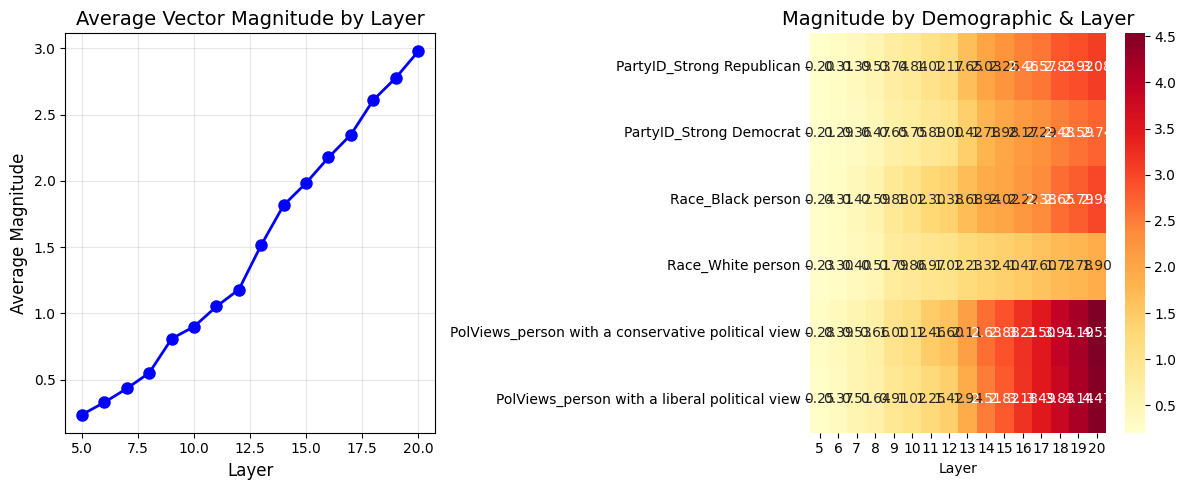

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Build DataFrame of magnitudes
magnitude_data = []
for layer_idx in LAYERS_TO_EXTRACT:
    vectors = all_layer_vectors[layer_idx]
    for label, data in vectors.items():
        magnitude_data.append({
            'layer': layer_idx,
            'demographic': label,
            'category': label.split('_')[0],
            'magnitude': data['magnitude']
        })

df_mag = pd.DataFrame(magnitude_data)

# Plot: Average magnitude by layer
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
avg_by_layer = df_mag.groupby('layer')['magnitude'].mean()
plt.plot(avg_by_layer.index, avg_by_layer.values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Average Magnitude', fontsize=12)
plt.title('Average Vector Magnitude by Layer', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Heatmap: magnitude by demographic and layer
pivot = df_mag.pivot(index='demographic', columns='layer', values='magnitude')
# Show only a subset for readability
sample_demos = ['PartyID_Strong Republican', 'PartyID_Strong Democrat',
                'Race_Black person', 'Race_White person',
                'PolViews_person with a conservative political view',
                'PolViews_person with a liberal political view']
pivot_subset = pivot.loc[[d for d in sample_demos if d in pivot.index]]
sns.heatmap(pivot_subset, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Magnitude by Demographic & Layer', fontsize=14)
plt.xlabel('Layer')
plt.ylabel('')

plt.tight_layout()
plt.show()

## PCA Visualization for Each Layer

In [ ]:
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap

# Create PCA plots for layers 5, 12, and 20
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, layer_idx in enumerate([5, 12, 20]):
    vectors = all_layer_vectors[layer_idx]

    # Prepare data
    labels = []
    vectors_list = []
    categories = []

    for key, data in vectors.items():
        vec = data['vector'].cpu().numpy()
        if not (np.isnan(vec).any() or np.isinf(vec).any()):
            vectors_list.append(vec)
            labels.append(key)
            categories.append(key.split('_')[0])

    X = np.array(vectors_list)

    # PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Plot with distinct colors for ~25 categories
    ax = axes[idx]
    unique_cats = sorted(set(categories))
    n_cats = len(unique_cats)

    # Use tab20 + tab20b for enough distinct colors
    if n_cats <= 20:
        colors = [get_cmap('tab20')(i / 20) for i in range(n_cats)]
    else:
        tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
        tab20b = [get_cmap('tab20b')(i / 20) for i in range(n_cats - 20)]
        colors = tab20 + tab20b
    cat_to_color = {cat: colors[i] for i, cat in enumerate(unique_cats)}

    df_plot = pd.DataFrame({
        'x': X_2d[:, 0], 'y': X_2d[:, 1],
        'category': categories, 'label': labels
    })

    for cat in unique_cats:
        mask = df_plot['category'] == cat
        ax.scatter(df_plot.loc[mask, 'x'], df_plot.loc[mask, 'y'],
                   label=cat, color=cat_to_color[cat], alpha=0.7, s=60, edgecolors='white', linewidth=0.3)

    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_title(f'Layer {layer_idx}', fontsize=14)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    if idx == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, ncol=2)

plt.suptitle('PCA of Demographic Vectors Across Layers (120 vectors)', fontsize=16)
plt.tight_layout()
plt.show()

## Summary

This notebook extracts **120 demographic steering vectors** (across 25 variables) from layers 5-20 of Meta-Llama-3-8B-Instruct.

**Variables covered:** Race, PartyID, Sex, Degree, Religion, PolViews, Generation, Marital, Age, Children, ImmigGen, Region16, FamilyIncome, Region, Urbanity, Occupation (SOC), Industry (NAICS), Happy, Health, Life, SatJob, Class, SatFin, OwnGun, God

**Output files:**
```
vectors/
├── gss_demographic_vectors_layer5.pt   (120 vectors each)
├── gss_demographic_vectors_layer6.pt
├── ...
└── gss_demographic_vectors_layer20.pt
```

**Next steps:**
- Use `2_simulate_steering_vectors.ipynb` to test steering effectiveness
- Use `3_investigate_correlations.ipynb` to analyze how steering affects other demographics
- Use `5_demographic_space_pca.ipynb` to map the "Demographic Space" via PCA

**Important:** For steering experiments, always use vectors extracted at the SAME layer as the injection layer.